In [5]:
import torch

classes = sorted(["baseball", "basketball", "football", "golf", "hockey", "rugby", "swimming", "tennis", "volleyball", "weightlifting"])

def unnormalize(image):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return image * std + mean

def saliency_map(model, input_image):
    model.eval()

    input_image = input_image.clone().detach().requires_grad_(True)
    model.zero_grad()

    output = model(input_image.unsqueeze(0))

    target_class = output.argmax(dim=1)
    target_score = output[0, target_class]

    target_score.backward()

    sal = input_image.grad.data.abs().squeeze()

    if sal.dim() == 3:
        sal, _ = sal.max(dim=0)

    sal = sal / (sal.max() + 1e-5)

    return sal.cpu()

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)

    def __call__(self, input_tensor, target_class=None):
        self.model.zero_grad()

        output = self.model(input_tensor.unsqueeze(0))

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        loss = output[0, target_class]
        loss.backward()

        gradients = self.gradients.squeeze(0)
        activations = self.activations.squeeze(0)

        weights = gradients.mean(dim=(1, 2), keepdim=True)

        cam = (weights * activations).sum(dim=0)
        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= cam.max() + 1e-5

        cam_upsampled = torch.nn.functional.interpolate(
            cam.unsqueeze(0).unsqueeze(0),
            size=(32, 32),
            mode='bilinear',
            align_corners=False
        ).squeeze()

        return cam_upsampled.cpu().numpy()
    
def overlay_image(original, overlay, colormap):
    overlayed = 0.6*original + 0.4*colormap(overlay)[:, :, :3]
    overlayed = overlayed / overlayed.max()
    return overlayed

In [6]:
from models import CNNModel, MultiLayerPerceptron, test_loader
from matplotlib import pyplot as plt

def check_class_performance(model):
	class_performance = [{ "correct": 0, "incorrect": 0} for cls in classes]

	model.eval()
	
	param_count = sum(p.numel() for p in model.parameters())
	print(f'Parameter Count: {param_count}')

	for images, labels in test_loader:
		for i in range(len(images)):
			predicted = model(images[i].unsqueeze(0))
			predicted_idx = torch.argmax(predicted, dim=1).item()

			correct_idx = labels[i]

			if correct_idx == predicted_idx:
				class_performance[correct_idx]["correct"] += 1
			else:
				class_performance[correct_idx]["incorrect"] += 1

	for i in range(len(class_performance)):
		performance = class_performance[i]

		print(f'{classes[i]}: {performance["correct"]} / {performance["correct"] + performance["incorrect"]}')

mlp_model = MultiLayerPerceptron()
mlp_model.load("checkpoints/mlp-original.pt")

print("MLP Model:")
check_class_performance(mlp_model)
print("\n")

cnn_model = CNNModel()
cnn_model.load("checkpoints/cnn-original.pt")

print("CNN Model:")
check_class_performance(cnn_model)

MLP Model:
Parameter Count: 1723466
baseball: 2 / 5
basketball: 4 / 5
football: 0 / 5
golf: 2 / 5
hockey: 5 / 5
rugby: 2 / 5
swimming: 5 / 5
tennis: 3 / 5
volleyball: 2 / 5
weightlifting: 3 / 5


CNN Model:
Parameter Count: 141610
baseball: 4 / 5
basketball: 3 / 5
football: 4 / 5
golf: 4 / 5
hockey: 5 / 5
rugby: 5 / 5
swimming: 5 / 5
tennis: 5 / 5
volleyball: 1 / 5
weightlifting: 5 / 5


MLP Model:
Interpreting Class: baseball
Correct:


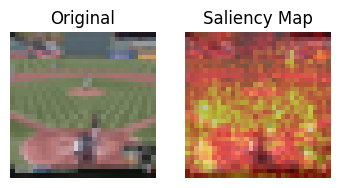

Incorrect (football):


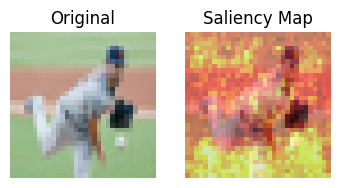

Interpreting Class: basketball
Correct:


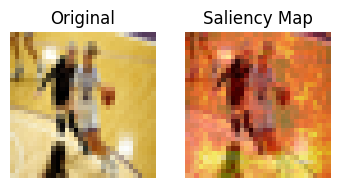

Incorrect (weightlifting):


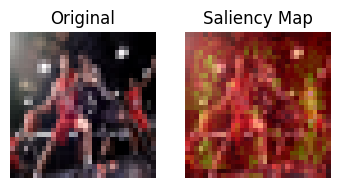

Interpreting Class: golf
Correct:


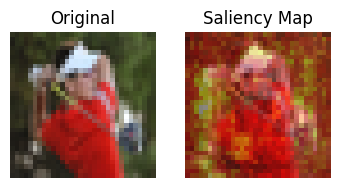

Incorrect (hockey):


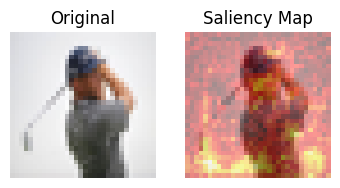



CNN Model:
Interpreting Class: baseball
Correct:


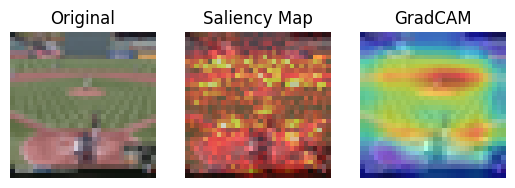

Incorrect (tennis):


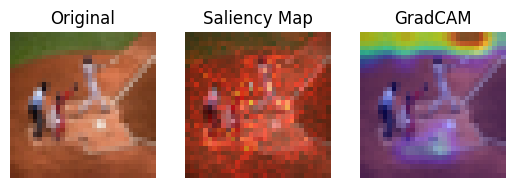

Interpreting Class: basketball
Correct:


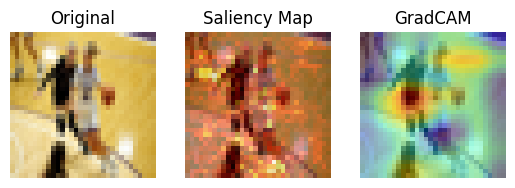

Incorrect (rugby):


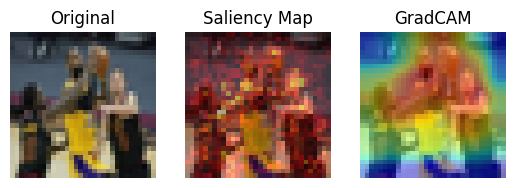

Interpreting Class: golf
Correct:


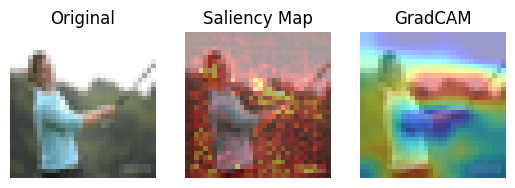

Incorrect (football):


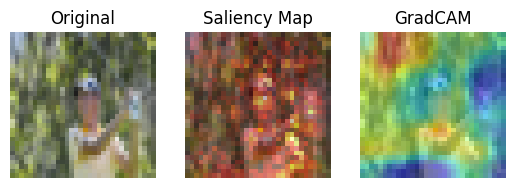

In [7]:
from models import CNNModel, MultiLayerPerceptron, test_loader
from matplotlib import pyplot as plt

def find_correct(model, cls):
    class_index = classes.index(cls)

    for images, labels in test_loader:
        for i in range(len(images)):
            predicted = model(images[i].unsqueeze(0))
            predicted = torch.argmax(predicted, dim=1).item()

            if predicted == labels[i] and predicted == class_index:
                return images[i]
            
def find_incorrect(model, cls):
    class_index = classes.index(cls)

    for images, labels in test_loader:
        for i in range(len(images)):
            predicted = model(images[i].unsqueeze(0))
            predicted = torch.argmax(predicted, dim=1).item()

            if predicted != labels[i] and labels[i] == class_index:
                return images[i], classes[predicted]
            
def visualize_image(model, original, gradcam):
    image = unnormalize(original).permute(1, 2, 0).cpu().numpy()

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap=None)
    plt.title("Original")
    plt.axis('off')

    saliency = saliency_map(model, original)
    saliency = saliency.numpy()
    
    plt.subplot(1, 3, 2)
    plt.imshow(overlay_image(image, saliency, plt.cm.hot), cmap='hot')
    plt.title("Saliency Map")
    plt.axis('off')

    if gradcam != None:
        plt.subplot(1, 3, 3)
        plt.imshow(overlay_image(image, gradcam(original), plt.cm.jet), cmap='hot')
        plt.title("GradCAM")
        plt.axis('off')
        
    plt.show()

def interpret_model(model, gradcam):
    model.eval()

    for cls in ['baseball', 'basketball', 'golf']:
        print(f'Interpreting Class: {cls}')

        print("Correct:")
        visualize_image(model, find_correct(model, cls), gradcam)

        incorrect_image, incorrect_class = find_incorrect(model, cls)
        print(f'Incorrect ({incorrect_class}):')

        visualize_image(model, incorrect_image, gradcam)

mlp_model = MultiLayerPerceptron()
mlp_model.load("checkpoints/mlp-original.pt")

print("MLP Model:")
interpret_model(mlp_model, None)
print("\n")

cnn_model = CNNModel()
cnn_model.load("checkpoints/cnn-original.pt")

print("CNN Model:")
interpret_model(cnn_model, GradCAM(cnn_model, cnn_model.features[14]))